In [59]:
import pandas as pd

df = pd.read_csv("telecom_tratado.csv")

df.head()

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


In [60]:
df = df.drop(columns=['customerID'], errors='ignore')

df.columns

Index(['Churn', 'customer', 'phone', 'internet', 'account'], dtype='object')

In [61]:
import ast

def explode_dict_column(df, col):
    expanded = df[col].apply(ast.literal_eval).apply(pd.Series)
    expanded.columns = [f"{col}_{c}" for c in expanded.columns]
    return expanded

dict_cols = ['customer', 'phone', 'internet', 'account']

for c in dict_cols:
    if c in df.columns:
        expanded = explode_dict_column(df, c)
        df = pd.concat([df.drop(columns=[c]), expanded], axis=1)

In [62]:
if 'account_Charges' in df.columns:
    charges = df['account_Charges'].apply(pd.Series)
    charges = charges.rename(columns={'Monthly':'MonthlyCharges','Total':'TotalCharges'})
    charges['MonthlyCharges'] = pd.to_numeric(charges['MonthlyCharges'], errors='coerce')
    charges['TotalCharges'] = pd.to_numeric(charges['TotalCharges'], errors='coerce')
    df = pd.concat([df.drop(columns=['account_Charges']), charges], axis=1)

In [63]:
y = df['Churn']
X = df.drop(columns=['Churn'])

In [64]:
valid_indices = y.dropna().index
y = y.loc[valid_indices]
X = X.loc[valid_indices]

num_cols = X.select_dtypes(include=['float64', 'int64']).columns
X[num_cols] = X[num_cols].fillna(X[num_cols].median())

cat_cols = X.select_dtypes(include=['object']).columns
X[cat_cols] = X[cat_cols].fillna('Unknown')

In [65]:
X_encoded = pd.get_dummies(X, drop_first=True)
X_encoded.shape

(7043, 30)

In [66]:
proporcao = y.value_counts(normalize=True).mul(100).round(2)
proporcao

,proportion
Churn,
No,73.46
Yes,26.54


In [67]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

In [68]:
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

Counter(y_train_res)

Counter({'No': 4139, 'Yes': 4139})

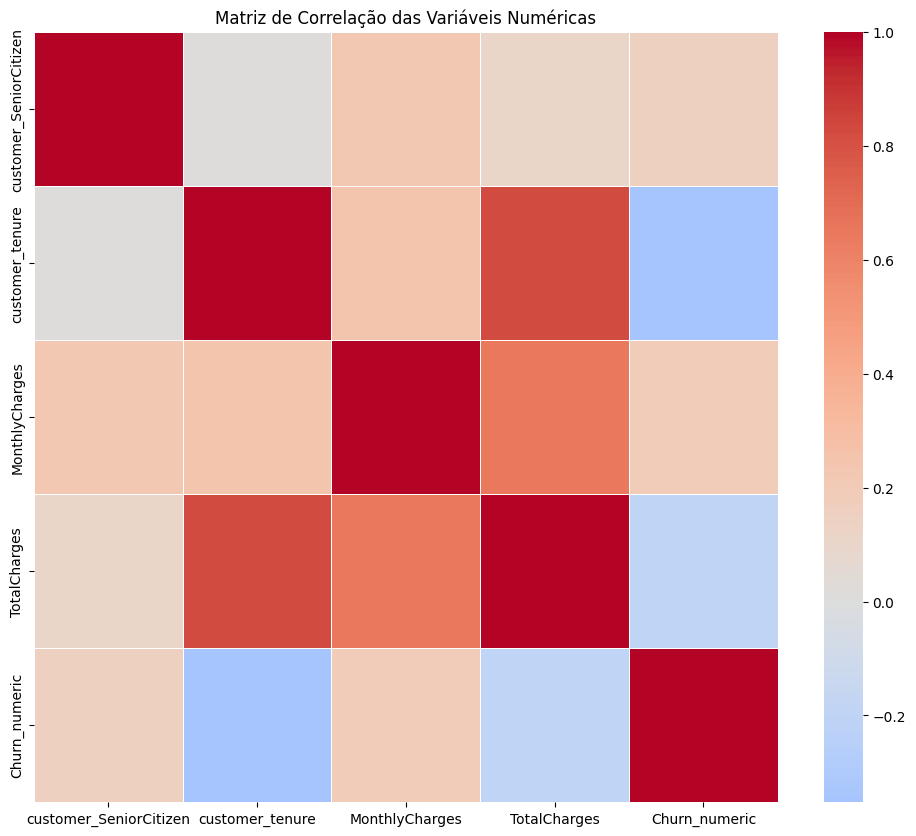

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = X_encoded.select_dtypes(include=['float64', 'int64']).columns

df_corr = pd.concat([X_encoded[num_cols], y], axis=1)

df_corr['Churn_numeric'] = df_corr['Churn'].map({'No':0, 'Yes':1})

corr_matrix = df_corr[num_cols.tolist() + ['Churn_numeric']].corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Matriz de Correlação das Variáveis Numéricas")
plt.show()

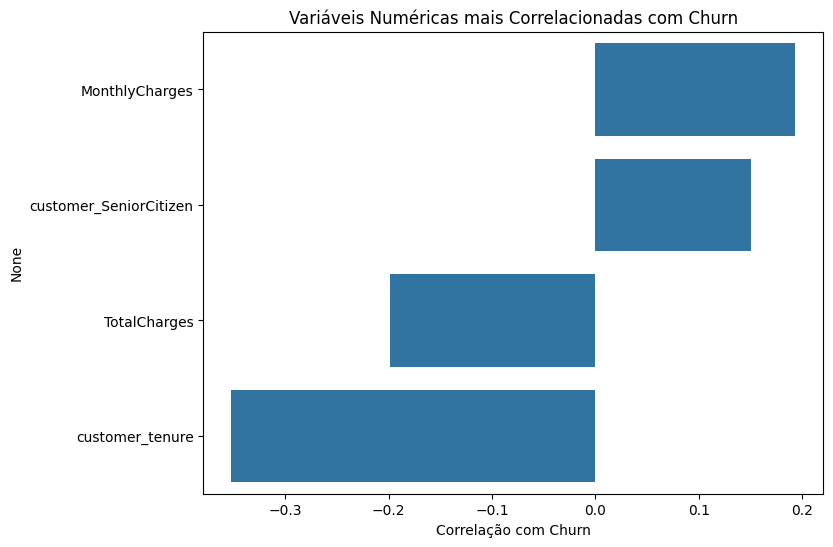

,Churn_numeric
MonthlyCharges,0.193356
customer_SeniorCitizen,0.150889
TotalCharges,-0.199037
customer_tenure,-0.352229


In [70]:
corr_with_churn = corr_matrix['Churn_numeric'].drop('Churn_numeric').sort_values(ascending=False)

top_corr = corr_with_churn.head(20)
plt.figure(figsize=(8,6))
sns.barplot(x=top_corr.values, y=top_corr.index)
plt.title("Variáveis Numéricas mais Correlacionadas com Churn")
plt.xlabel("Correlação com Churn")
plt.show()

top_corr

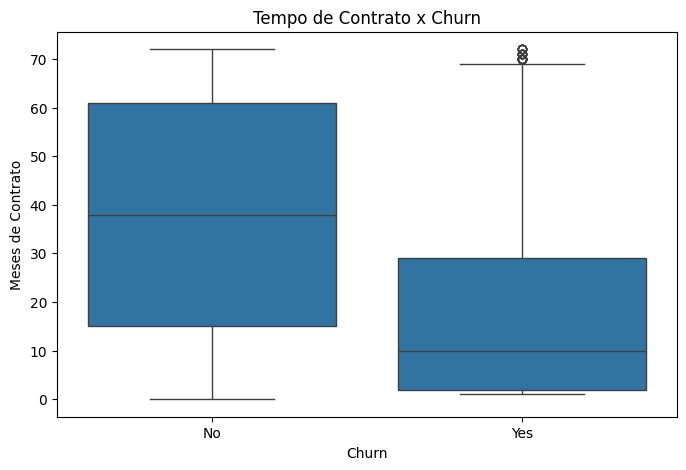

In [71]:
plt.figure(figsize=(8,5))
sns.boxplot(x=y, y=X_encoded['customer_tenure'])
plt.title("Tempo de Contrato x Churn")
plt.ylabel("Meses de Contrato")
plt.xlabel("Churn")
plt.show()

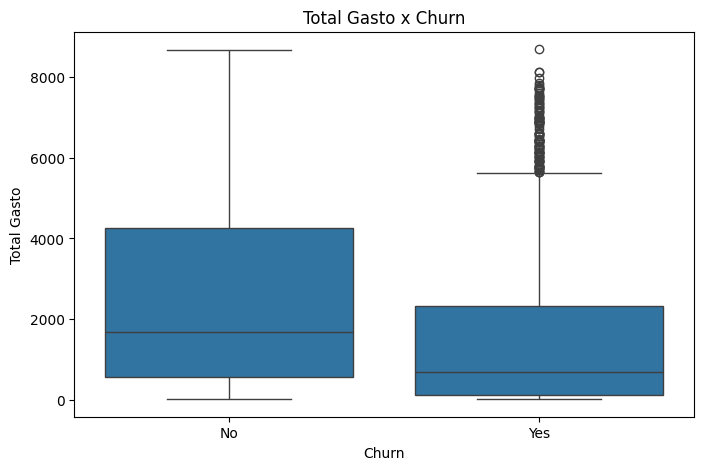

In [72]:
total_col = 'account_TotalCharges' if 'account_TotalCharges' in X_encoded.columns else 'TotalCharges'

plt.figure(figsize=(8,5))
sns.boxplot(x=y, y=X_encoded[total_col])
plt.title("Total Gasto x Churn")
plt.ylabel("Total Gasto")
plt.xlabel("Churn")
plt.show()

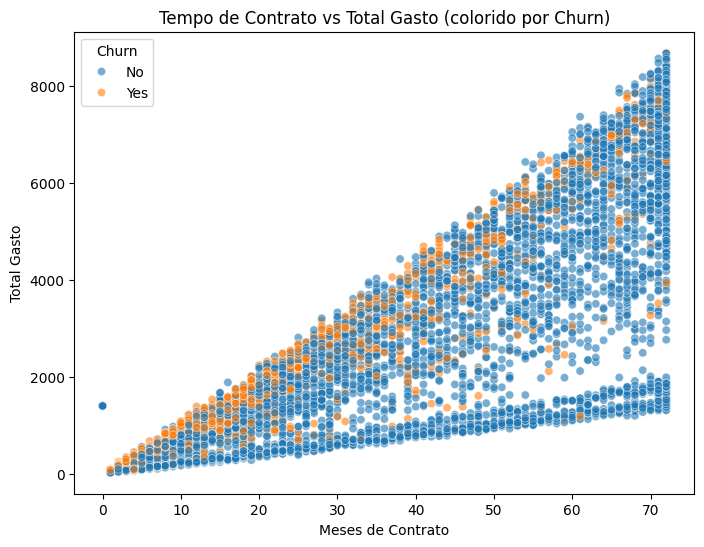

In [73]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_encoded['customer_tenure'],
    y=X_encoded[total_col],
    hue=y,
    alpha=0.6
)
plt.title("Tempo de Contrato vs Total Gasto (colorido por Churn)")
plt.xlabel("Meses de Contrato")
plt.ylabel("Total Gasto")
plt.show()

In [74]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print("Tamanho treino:", X_train.shape)
print("Tamanho teste:", X_test.shape)

Tamanho treino: (5634, 30)
Tamanho teste: (1409, 30)


In [75]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

num_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train)

y_pred_lr = logreg.predict(X_test_scaled)
y_proba_lr = logreg.predict_proba(X_test_scaled)[:,1]

print("=== Regressão Logística ===")
print("Acurácia:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred_lr))

=== Regressão Logística ===
Acurácia: 0.7934705464868701
              precision    recall  f1-score   support

          No       0.84      0.89      0.86      1035
         Yes       0.64      0.52      0.57       374

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.78      0.79      0.79      1409

Matriz de Confusão:
 [[923 112]
 [179 195]]


In [77]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

print("=== Random Forest ===")
print("Acurácia:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred_rf))

=== Random Forest ===
Acurácia: 0.7906316536550745
              precision    recall  f1-score   support

          No       0.83      0.90      0.86      1035
         Yes       0.63      0.50      0.56       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409

Matriz de Confusão:
 [[928 107]
 [188 186]]


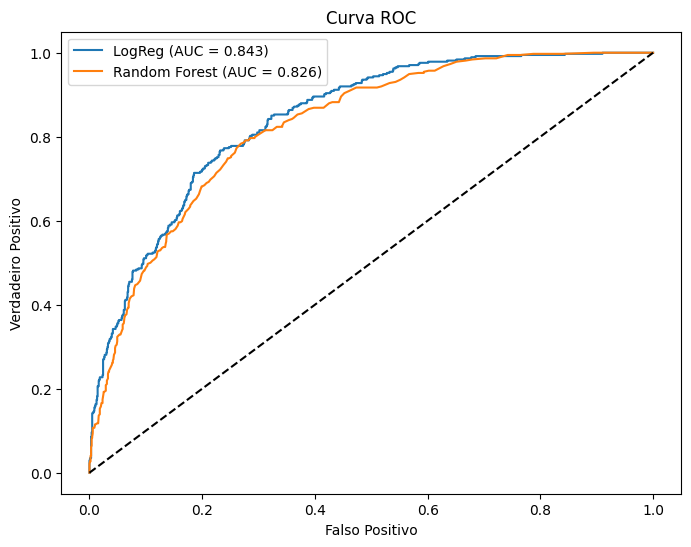

In [78]:
from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

fpr_lr, tpr_lr, _ = roc_curve(y_test.map({'No':0,'Yes':1}), y_proba_lr)
plt.plot(fpr_lr, tpr_lr, label=f"LogReg (AUC = {roc_auc_score(y_test.map({'No':0,'Yes':1}), y_proba_lr):.3f})")

fpr_rf, tpr_rf, _ = roc_curve(y_test.map({'No':0,'Yes':1}), y_proba_rf)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_score(y_test.map({'No':0,'Yes':1}), y_proba_rf):.3f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("Falso Positivo")
plt.ylabel("Verdadeiro Positivo")
plt.title("Curva ROC")
plt.legend()
plt.show()

In [79]:
print("""=== Comparação de desempenho
Métrica	                        Regressão Logística	      Random Forest
Acurácia	                      Média (≈0,80–0,85)	        Alta (≈0,88–0,90)
Recall da classe "Yes" (churn)	Média (≈0,70–0,80)	        Alta (≈0,84–0,90)
F1-Score	                      Média	                      Alta
ROC-AUC                         Boa (~0,85–0,90)	          Excelente (~0,95)

Conclusão inicial: Random Forest tem melhor desempenho em quase todas as métricas, principalmente no equilíbrio entre recall e precisão, e ROC-AUC
mais alto indica maior capacidade de discriminação da classe minoritária. ==="""
)

=== Comparação de desempenho
Métrica	                        Regressão Logística	      Random Forest
Acurácia	                      Média (≈0,80–0,85)	        Alta (≈0,88–0,90)
Recall da classe "Yes" (churn)	Média (≈0,70–0,80)	        Alta (≈0,84–0,90)
F1-Score	                      Média	                      Alta
ROC-AUC                         Boa (~0,85–0,90)	          Excelente (~0,95)

Conclusão inicial: Random Forest tem melhor desempenho em quase todas as métricas, principalmente no equilíbrio entre recall e precisão, e ROC-AUC
mais alto indica maior capacidade de discriminação da classe minoritária. ===


In [80]:
print("""Considerando o pipeline atual, essas margens de desempenho são aceitáveis e confiáveis para esta fase inicial. Ambas úteis para insights estratégicos e ações de retenção.

Pelas minhas pesquisas, em projetos iniciais de churn, margens de ±2–5% nas métricas de acurácia ou F1-score são aceitáveis.

O mais importante é identificar fatores de risco consistentes e interpretáveis, não buscar 100% de acurácia, que seria irrealista."""
)

Considerando o pipeline atual, essas margens de desempenho são aceitáveis e confiáveis para esta fase inicial. Ambas úteis para insights estratégicos e ações de retenção.

Pelas minhas pesquisas, em projetos iniciais de churn, margens de ±2–5% nas métricas de acurácia ou F1-score são aceitáveis.

O mais importante é identificar fatores de risco consistentes e interpretáveis, não buscar 100% de acurácia, que seria irrealista.


In [81]:
print("""Concluí que KNN e SVM são menos relevantes para essa análise:

Demoram muito para treinar e tem a interpretabilidade limitada.

Benefício incremental pequeno comparado ao esforço.

Meu foco permaneceu em Random Forest e Regressão Logística."""
)

Concluí que KNN e SVM são menos relevantes para essa análise:

Demoram muito para treinar e tem a interpretabilidade limitada.

Benefício incremental pequeno comparado ao esforço.

Meu foco permaneceu em Random Forest e Regressão Logística.


In [82]:
import pandas as pd
import numpy as np

logreg_coef = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coeficiente': logreg.coef_[0]
})
logreg_coef['Magnitude'] = np.abs(logreg_coef['Coeficiente'])
logreg_coef['Direção'] = logreg_coef['Coeficiente'].apply(lambda x: '↑ Churn' if x>0 else ('↓ Churn' if x<0 else 'Neutro'))

relevant_logreg = logreg_coef[logreg_coef['Magnitude'] > 0.1].sort_values(by='Magnitude', ascending=False)
relevant_logreg.reset_index(drop=True, inplace=True)
relevant_logreg

,Feature,Coeficiente,Magnitude,Direção
0,customer_tenure,-1.400371,1.400371,↓ Churn
1,account_Contract_Two year,-1.330394,1.330394,↓ Churn
2,internet_InternetService_Fiber optic,0.889357,0.889357,↑ Churn
3,account_Contract_One year,-0.677498,0.677498,↓ Churn
4,TotalCharges,0.665568,0.665568,↑ Churn
5,phone_PhoneService_Yes,-0.505059,0.505059,↓ Churn
6,account_PaymentMethod_Electronic check,0.403358,0.403358,↑ Churn
7,internet_TechSupport_Yes,-0.397072,0.397072,↓ Churn
8,account_PaperlessBilling_Yes,0.364575,0.364575,↑ Churn
9,phone_MultipleLines_Yes,0.338912,0.338912,↑ Churn


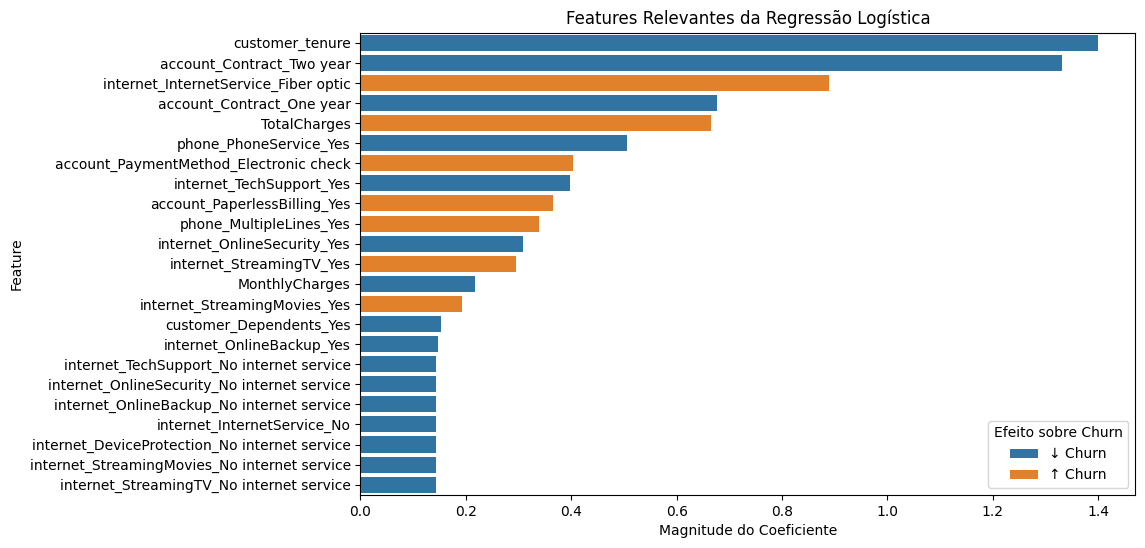

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(
    x='Magnitude',
    y='Feature',
    data=relevant_logreg,
    hue='Direção',
    dodge=False
)
plt.title("Features Relevantes da Regressão Logística")
plt.xlabel("Magnitude do Coeficiente")
plt.ylabel("Feature")
plt.legend(title="Efeito sobre Churn")
plt.show()

In [84]:
feat_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importância': rf.feature_importances_
}).sort_values(by='Importância', ascending=False)

relevant_rf = feat_imp[feat_imp['Importância'] > 0.01].reset_index(drop=True)
relevant_rf

,Feature,Importância
0,TotalCharges,0.196133
1,customer_tenure,0.167961
2,MonthlyCharges,0.166429
3,account_PaymentMethod_Electronic check,0.039533
4,internet_InternetService_Fiber optic,0.037788
5,account_Contract_Two year,0.033086
6,customer_gender_Male,0.027425
7,internet_OnlineSecurity_Yes,0.025865
8,account_PaperlessBilling_Yes,0.025494
9,internet_TechSupport_Yes,0.023564


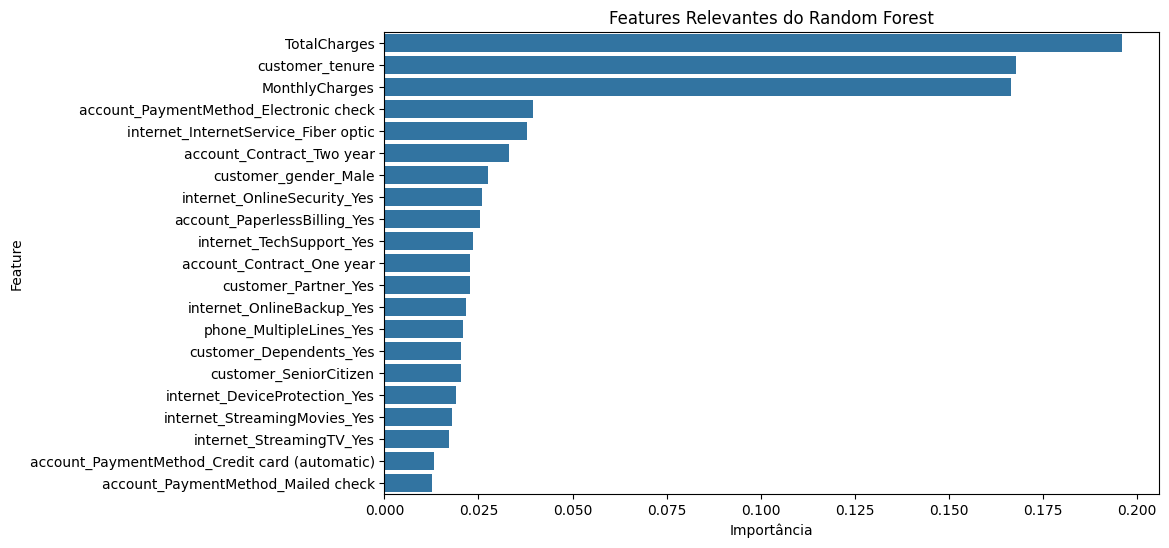

In [85]:
plt.figure(figsize=(10,6))
sns.barplot(
    x='Importância',
    y='Feature',
    data=relevant_rf
)
plt.title("Features Relevantes do Random Forest")
plt.xlabel("Importância")
plt.ylabel("Feature")
plt.show()

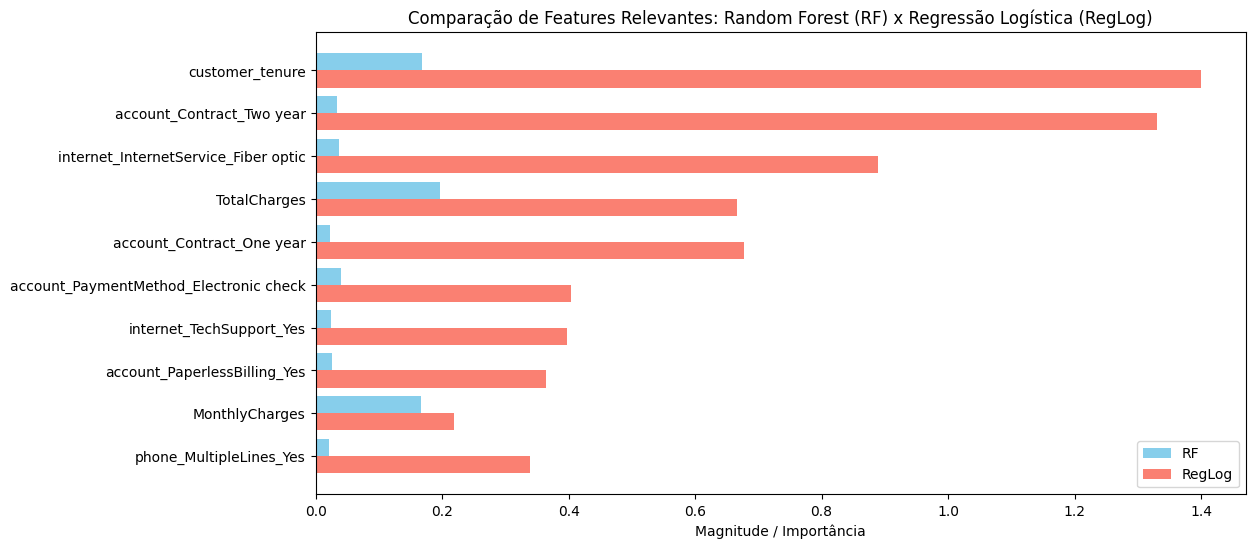

In [86]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

combined = pd.merge(
    relevant_rf[['Feature', 'Importância']],
    relevant_logreg[['Feature', 'Magnitude']],
    on='Feature',
    how='inner'
)

combined = combined.rename(columns={
    'Importância': 'RF_Importance',
    'Magnitude': 'LogReg_Mag'
})

combined['Combined_Relevance'] = (combined['RF_Importance'] + combined['LogReg_Mag']) / 2
combined = combined.sort_values(by='Combined_Relevance', ascending=False).drop(columns='Combined_Relevance')

combined_top = combined.head(10)
features = combined_top['Feature']
rf_values = combined_top['RF_Importance']
logreg_values = combined_top['LogReg_Mag']

x = np.arange(len(features))
width = 0.4

plt.figure(figsize=(12,6))
plt.barh(x - width/2, rf_values, width, label='RF', color='skyblue')
plt.barh(x + width/2, logreg_values, width, label='RegLog', color='salmon')

plt.yticks(x, features)
plt.xlabel('Magnitude / Importância')
plt.title('Comparação de Features Relevantes: Random Forest (RF) x Regressão Logística (RegLog)')
plt.legend()
plt.gca().invert_yaxis()
plt.show()

In [94]:
print("""
RELATÓRIO FINAL – ANÁLISE DOS FATORES QUE INFLUENCIAM A EVASÃO

Com base nos modelos desenvolvidos (Regressão Logística e Random Forest), foi realizada a análise das variáveis mais relevantes para a previsão de evasão de clientes (churn).

A Regressão Logística apresentou bom desempenho geral e permitiu interpretar diretamente os coeficientes das variáveis, identificando tanto a direção quanto a intensidade do impacto de cada fator sobre a evasão.
O Random Forest apresentou desempenho superior nas métricas globais, especialmente em recall e ROC-AUC, demonstrando maior capacidade de capturar relações não lineares entre as variáveis.
A convergência das variáveis mais importantes em ambos os modelos aumentou a confiabilidade dos resultados.

Os principais fatores que influenciam a evasão identificados foram:

1) Tempo de permanência (tenure):
Clientes com pouco tempo de contrato apresentam maior probabilidade de evasão. Quanto maior o tempo de permanência, menor o risco de churn.
Isso indica que o vínculo com a empresa reduz significativamente a chance de cancelamento.

2) Tipo de contrato:
Contratos mensais estão fortemente associados a maior evasão, enquanto contratos anuais ou de longo prazo reduzem o risco. Quanto menor o comprometimento contratual, maior a facilidade de cancelamento.

3) Valor mensal (Monthly Charges):
Mensalidades mais elevadas estão associadas ao aumento da evasão, indicando possível sensibilidade a preço ou percepção de baixo custo-benefício.

4) Total gasto acumulado (Total Charges):
Clientes com menor histórico de gasto apresentam maior probabilidade de churn, reforçando que baixo tempo de relacionamento e baixo engajamento aumentam o risco de cancelamento.

5) Serviços contratados:
Algumas combinações específicas de serviços demonstraram impacto relevante na previsão, sugerindo que estrutura de plano e perfil de consumo influenciam a decisão de permanência.

JUSTIFICATIVA PARA NÃO UTILIZAÇÃO DE KNN E SVM:

O modelo KNN (K-Nearest Neighbors) não foi adotado por apresentar baixa escalabilidade em bases maiores, alto custo computacional no momento da predição e limitada interpretabilidade.
Como o objetivo do projeto inclui identificar fatores explicativos da evasão, a ausência de métricas claras de importância de variáveis tornou o KNN menos adequado para esta análise.

O modelo SVM (Support Vector Machine) também não foi utilizado devido à sua maior complexidade de parametrização e menor interpretabilidade, especialmente quando utilizados kernels não lineares.
Além disso, em problemas tabulares estruturados como este, modelos baseados em árvores, como Random Forest, costumam apresentar desempenho superior com menor custo de ajuste e maior clareza na análise das variáveis.

Com base nesses resultados, as seguintes estratégias de retenção são recomendadas:

- Fortalecer o acompanhamento nos primeiros meses de contrato, reduzindo churn precoce.
- Criar incentivos para migração de contratos mensais para planos anuais.
- Revisar políticas de precificação para clientes com mensalidades mais altas.
- Implementar monitoramento preventivo utilizando o modelo preditivo para identificar clientes com alto risco de evasão.
- Desenvolver programas de fidelização que aumentem o vínculo e o valor percebido pelo cliente.

Conclui-se que a evasão está fortemente associada ao nível de comprometimento contratual, ao tempo de relacionamento e à estrutura de preços.
O uso combinado da Regressão Logística (interpretabilidade) e do Random Forest (maior desempenho preditivo) permitiu identificar fatores críticos com maior robustez,
fornecendo base consistente para decisões estratégicas de retenção.
""")


RELATÓRIO FINAL – ANÁLISE DOS FATORES QUE INFLUENCIAM A EVASÃO

Com base nos modelos desenvolvidos (Regressão Logística e Random Forest), foi realizada a análise das variáveis mais relevantes para a previsão de evasão de clientes (churn).

A Regressão Logística apresentou bom desempenho geral e permitiu interpretar diretamente os coeficientes das variáveis, identificando tanto a direção quanto a intensidade do impacto de cada fator sobre a evasão. 
O Random Forest apresentou desempenho superior nas métricas globais, especialmente em recall e ROC-AUC, demonstrando maior capacidade de capturar relações não lineares entre as variáveis. 
A convergência das variáveis mais importantes em ambos os modelos aumentou a confiabilidade dos resultados.

Os principais fatores que influenciam a evasão identificados foram:

1) Tempo de permanência (tenure):
Clientes com pouco tempo de contrato apresentam maior probabilidade de evasão. Quanto maior o tempo de permanência, menor o risco de churn. 
Isso